In [1]:
import numpy as np
import pandas as pd
import pydot
from IPython.display import Image, display

In [2]:
class Node(object):
    def __init__(self):
        self.value = None              # feature name to split the current node / class label at leaf node
        self.pathCondition = None      # to follow path if value == pathCondition
        self.children = None           # all child subtrees of the node
        self.entropy = None            # entropy of the node
        self.samples = None            # number of samples in node

In [3]:
def getEntropyOfNode(target_column):
    
    entropy = 0
    
    classes = pd.unique(target_column)
    
    # Total number of samples in target column T
    msamples = target_column.shape[0]
    
    for c in classes:
        # Total occurences of class c in T
        mc = target_column[ target_column == c ].shape[0]
        
        probability_c = mc/ msamples
        
        if probability_c != 0:
            entropy += probability_c * np.log2(probability_c)
        else:
            entropy += 0
        
        if probability_c == 1:
            return 0, c
        
    return -entropy, -1

In [4]:
def get_information_gain(entropy_before, entropy_after):
    
    information_gain = entropy_before - entropy_after
    
    return information_gain

In [5]:
def findBestSplit(df, features):
    """Find the best question to ask by iterating over every feature / value
    and calculating the information gain."""
    
    maxGain = 0
    F = -1    #index of feature that best splits the dataset
    
    entropy_before, leaf_label = getEntropyOfNode(df[target])
    
    if entropy_before == 0:
        # meaning its a leaf node
        return maxGain, F, leaf_label
    
    T = df.shape[0]
    
    for f in features:
        
        # all unique values in feature column f
        K = pd.unique(df[f])
        
        entropy_after = 0
        
        for k in K:
            Tk = df[df[f] == k].shape[0]
            
            entropy, leaf_label = getEntropyOfNode(df[df[f] == k][target])
            
            entropy_after += (Tk/T)* entropy
            
        information_gain = get_information_gain(entropy_before, entropy_after)
            
        if information_gain > maxGain:
            F = features.index(f)
            maxGain = information_gain
            
    
    return maxGain, F, leaf_label

In [6]:
def build_ID3(df, features):
    
    maxGain, F, leaf_label = findBestSplit(df, features)
    
    root = Node()
    root.children = []

    if maxGain == 0:
        # in case the node is a leaf node then set the value of node as class label
        root.value = leaf_label
        root.samples = df.shape[0]
        root.entropy = 0
        
        return root
    
    node_entropy, _ = getEntropyOfNode(df[target])
    root.entropy = np.round(node_entropy,2)
    root.samples = df.shape[0]
    root.value = features[F]
    
    F = features[F]
    features = [f for f in features if f!=F ]

    K = pd.unique(df[F])
    
    for k in K:
        subtree = build_ID3(df[df[F]==k][features+[target]], features)
        subtree.pathCondition = k
        root.children.append(subtree)
        
    return root

In [7]:
def tree_to_dot(tree):
    "Function to convert decision tree to dot format"

    node_style = {"shape":"", 'style':"filled", 'fillcolor':"yellow"}    
    graph_style = {'bgcolor':""}
    edge_style = {'color': ""}
    
    tree_graph = pydot.Dot(graph_type="digraph", strict=True, rankdir="TB", **graph_style)
    
    nodes = {}

    def recursive_append(parent_name, current_node):
        "Recursively iterate through the tree to export to dot by creating node and edges."
        
        _node_style = node_style.copy()
        _edge_style = edge_style.copy()
        
        if current_node.entropy != 0:
            node_label = "Split -> {}\n" +\
            "Entropy = {} \n"+ \
              "Samples = {}"
            
            node_label = node_label.format(current_node.value, current_node.entropy, current_node.samples)
        else:
            node_label = "{} = {}".format(target, current_node.value)
            _node_style["shape"] = "diamond"

        _edge_style['label'] = current_node.pathCondition

        if node_label in nodes.keys():
            nodes[node_label] = nodes[node_label] + 1 
        else:
            nodes[node_label] = 0

        node_name = node_label + str(nodes[node_label])

        if current_node.entropy == 0:
            _node_style["fillcolor"]="green"


        node = pydot.Node(name=node_name, label=node_label, **_node_style)
        tree_graph.add_node(node)

        if parent_name is not None:
            edge = pydot.Edge(parent_name, node_name, **_edge_style)
            tree_graph.add_edge(edge)

        for child in current_node.children:
            if child:
                recursive_append(node_name, child)

    recursive_append(None, tree)

    return tree_graph

### Training:

In [8]:
df = pd.read_csv("../datasets/playtennis.csv")

features = ['outlook', 'temp', 'humidity', 'wind']
target = 'play'

In [9]:
# Train Decision tree
id3_tree = build_ID3(df, features)

### Display Tree:

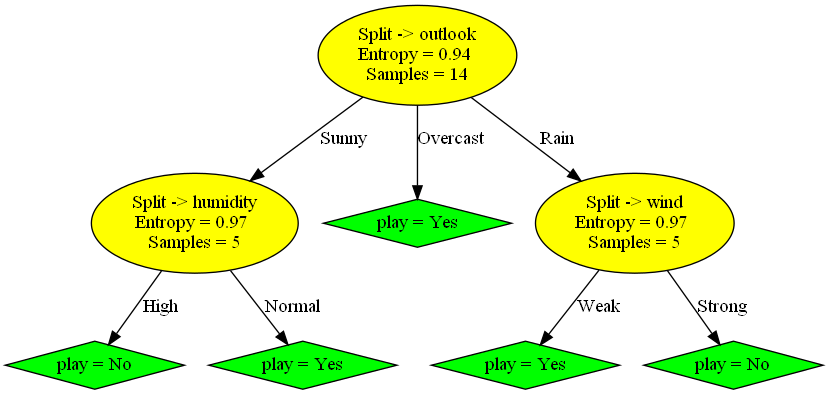

In [10]:
tree_graph = tree_to_dot(id3_tree)

# tree_graph.write_png("../snapshots/id3_tree.png")

# Display image directly without saving (requires IPython)
plt = Image(tree_graph.create_png())
display(plt)
